In [0]:
%pip install s3fs
%pip install sentence-transformers
%pip install lightgbm
%pip install transformers

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# CCF and SCF classification evaluation

In [0]:
# Load dataset
df = pd.read_csv(".../control_fg_ccf_scf.csv", header=0)

In [0]:
df_ccf = df[df["source"]=="ccf"]
df_scf = df[df["source"]=="scf"] # SCF is already filtered to the same framework as ccf

df_ccf.shape, df_scf.shape

Out[3]: ((218, 8), (1090, 8))

In [0]:
# Remove less frequent categories

def select_frequent_category(df, min_controls=10, verbose=False):
    df_stats = df.groupby("control_category").agg({"control": "count"}).reset_index()
    if verbose:
        print(df_stats)
    
    # Remove cateogory with less than 10 samples
    target_categories = df_stats[df_stats["control"] >= min_controls]["control_category"].tolist()
    return df[df["control_category"].isin(target_categories)], target_categories

df_ccf_selected, ccf_target_categories = select_frequent_category(df_ccf, min_controls=10)
# df_ccf_selected.groupby("control_category").agg({"control": "count"}).reset_index()

df_scf_selected, _ = select_frequent_category(df_scf, min_controls=10)
# df_scf_selected.groupby("control_category").agg({"control": "count"}).reset_index()

## 1. CCF Classifier

In [0]:
df_train_ccf, df_test_ccf = train_test_split(df_ccf_selected, test_size=0.20, stratify=df_ccf_selected.control_category, random_state=42)
df_train_ccf.shape, df_test_ccf.shape

Out[12]: ((132, 8), (34, 8))

In [0]:
# TF-IDF Feature Generation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [0]:
def evaluate(labels, y_pred, y_true):
    # calssification report
    print(classification_report(y_true, y_pred))
    # confusion metric
    cm = confusion_matrix(y_true, y_pred)    
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(ax=ax, xticks_rotation="vertical", cmap="cool")



def train_eval(model_pipeline, df_train, df_test):
    model_pipeline.fit(df_train.control, df_train.control_category)
    
    pred = model_pipeline.predict(df_test.control)
    evaluate(model_pipeline["model"].classes_, pred, df_test.control_category)
    return model_pipeline, pred

### Bert Zeroshot

In [0]:
import transformers
from transformers import pipeline
import numpy as np 

def get_predicted_label(zero_shot_clf_prediction):
    score = zero_shot_clf_prediction["scores"]
    label_set = zero_shot_clf_prediction["labels"]
    best_index = np.argmax(score)
    predicted_label = label_set[best_index]
    return predicted_label

In [0]:
labels = df_ccf_selected["control_category"].unique().tolist()
labels

Out[16]: ['Configuration Management',
 'Data Management',
 'Entity Management',
 'Identity and Access Management',
 'Network Operations',
 'Risk Management',
 'Security Governance',
 'Systems Monitoring',
 'Site Operations',
 'Third Party Management',
 'Vulnerability Management']

In [0]:
model = pipeline(model="facebook/bart-large-mnli", device=0, random_state=42)

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                precision  

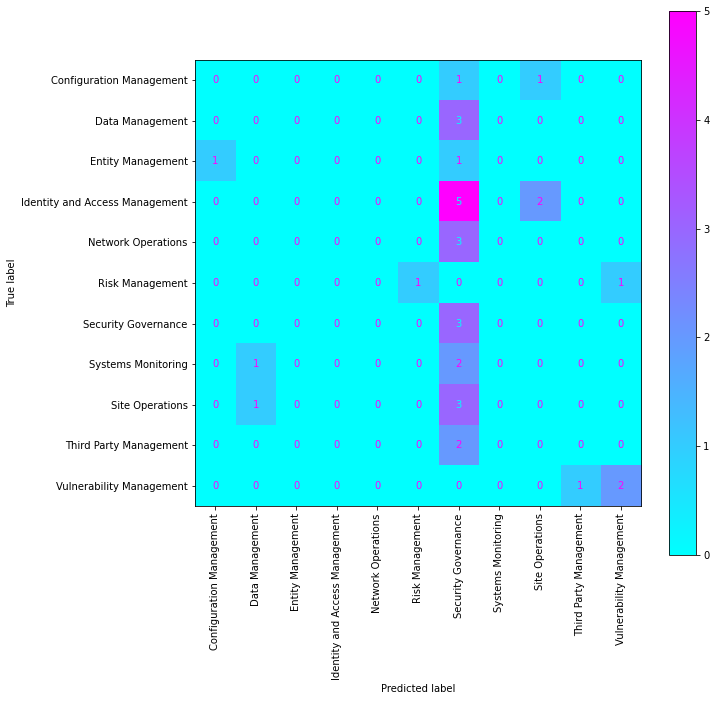

In [0]:
# Evaluate performance on test data
df_test_ccf["zero_shot_prediction"] = df_test_ccf["control"].apply(lambda x: model(x, candidate_labels=labels))
df_test_ccf["zero_shot_prediction_label"] = df_test_ccf["zero_shot_prediction"].apply(lambda x: get_predicted_label(x))

evaluate(labels, df_test_ccf["zero_shot_prediction_label"], df_test_ccf["control_category"])
# print(classification_report(, df_test["zero_shot_prediction_label"]))

/databricks/python/lib/python3.9/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<command-883378548096467>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ccf_selected["zero_shot_prediction"] = df_ccf_selected["control"].apply(lambda x: model(x, candidate_labels=labels))
<command-883378548096467>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ccf_selected["ze

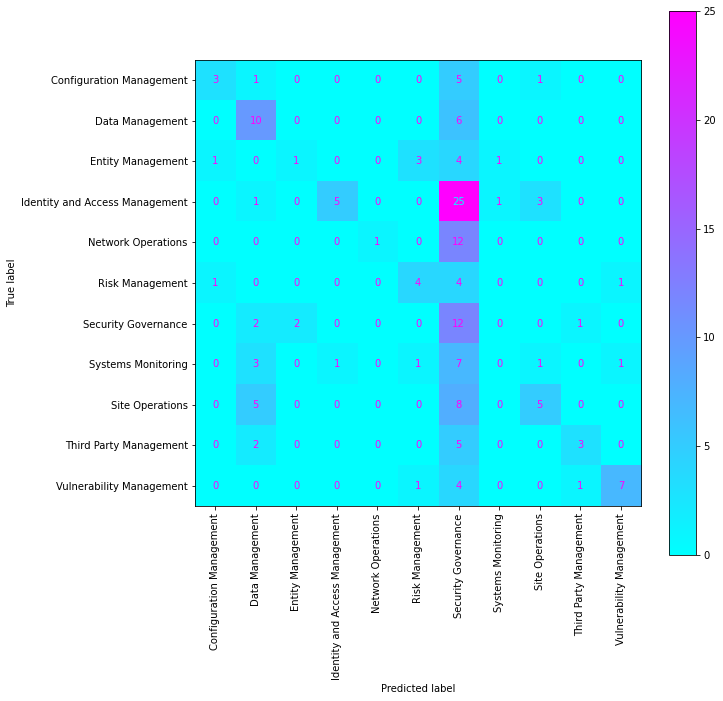

In [0]:
df_ccf_selected["zero_shot_prediction"] = df_ccf_selected["control"].apply(lambda x: model(x, candidate_labels=labels))
df_ccf_selected["zero_shot_prediction_label"] = df_ccf_selected["zero_shot_prediction"].apply(lambda x: get_predicted_label(x))

evaluate(labels, df_ccf_selected["zero_shot_prediction_label"], df_ccf_selected["control_category"])

### Logreg + CountVectorizer

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                precision  

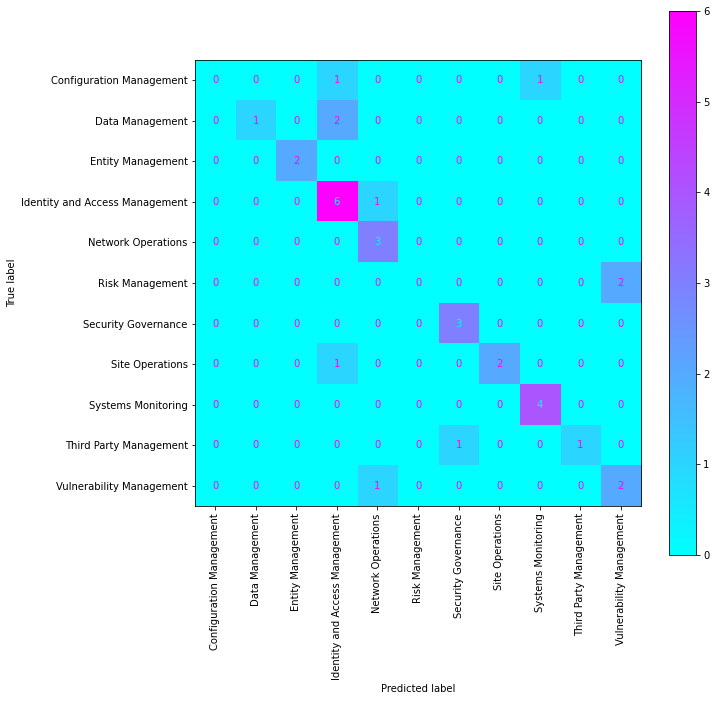

In [0]:
# logreg + CountVectorizer 
pipe_logreg = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 3), stop_words="english")), ('model', LogisticRegression(C=1e5))])
_, prediction = train_eval(pipe_logreg, df_train_ccf, df_test_ccf)

### Navie bayer + CountVectorizer

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                precision  

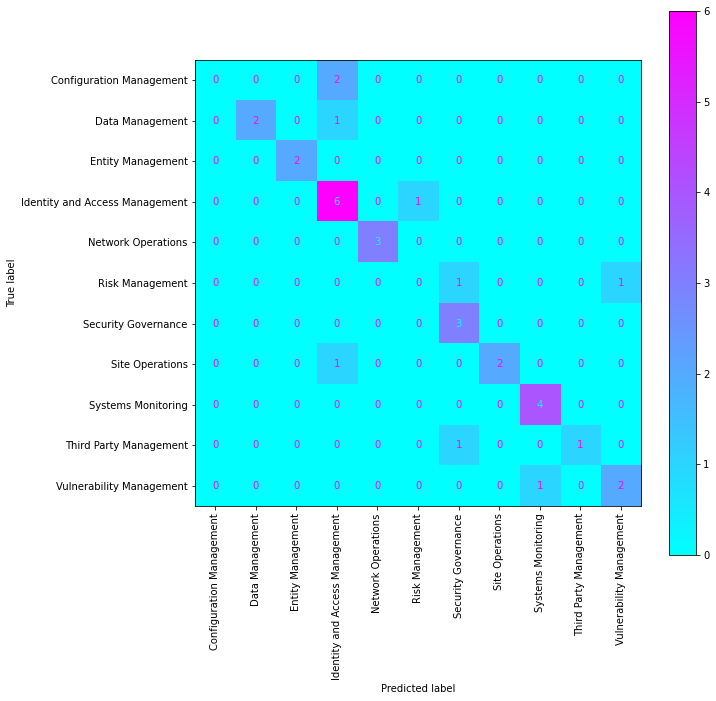

In [0]:
# navie bayer + CountVectorizer
pipe_nb = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 3), stop_words="english")), ('model', MultinomialNB())])
pipe_nb = train_eval(pipe_nb, df_train_ccf, df_test_ccf)

In [0]:
df_test_ccf["pred"] = prediction
df_errors_ccf = df_test_ccf[df_test_ccf.apply(lambda x: ( (x["pred"] == "Systems Monitoring") & (x["pred"] != x["control_category"])), axis=1)]
display(df_errors_ccf.head())

/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  A field of type StructType expects a pandas.DataFrame, but got: <class 'pandas.core.series.Series'>
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


org_id,control,framework_section_code,framework_section_title,source,control_category,control_sub_category,control_shortname,zero_shot_prediction,zero_shot_prediction_label,pred
NaN,[The organization] implements only one primary function per server within the production environment; the information system maintains a separate execution domain for each executing process.,NaN,NaN,ccf,Configuration Management,Baseline Configurations,Process Isolation,"Map(sequence -> [The organization] implements only one primary function per server within the production environment; the information system maintains a separate execution domain for each executing process., scores -> [0.1383114606142044, 0.11017921566963196, 0.10040528327226639, 0.09169977158308029, 0.09062578529119492, 0.09017646312713623, 0.08635017275810242, 0.08198119699954987, 0.07736726850271225, 0.07577343285083771, 0.057129938155412674], labels -> [Security Governance, Systems Monitoring, Site Operations, Vulnerability Management, Network Operations, Configuration Management, Entity Management, Data Management, Identity and Access Management, Third Party Management, Risk Management])",Security Governance,Systems Monitoring


### Logreg + Setence Bert

In [0]:
from sentence_transformers import SentenceTransformer

def train_eval_bert(model, df_train, df_test):
    embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device=0)

    X_train = embedder.encode(df_train.control.tolist())
    y_train = df_train.control_category
    
    X_test = embedder.encode(df_test.control.tolist())
    y_test = df_test.control_category
    
    model.fit(X_train, y_train) 
    preds = model.predict(X_test)
    
    evaluate(model.classes_, preds, df_test.control_category)
    return model, preds

                                precision    recall  f1-score   support

      Configuration Management       0.00      0.00      0.00         2
               Data Management       0.33      0.67      0.44         3
             Entity Management       1.00      1.00      1.00         2
Identity and Access Management       0.75      0.43      0.55         7
            Network Operations       0.60      1.00      0.75         3
               Risk Management       0.00      0.00      0.00         2
           Security Governance       0.00      0.00      0.00         3
               Site Operations       1.00      1.00      1.00         3
            Systems Monitoring       0.67      0.50      0.57         4
        Third Party Management       0.33      0.50      0.40         2
      Vulnerability Management       0.50      1.00      0.67         3

                      accuracy                           0.56        34
                     macro avg       0.47      0.55      0.49 

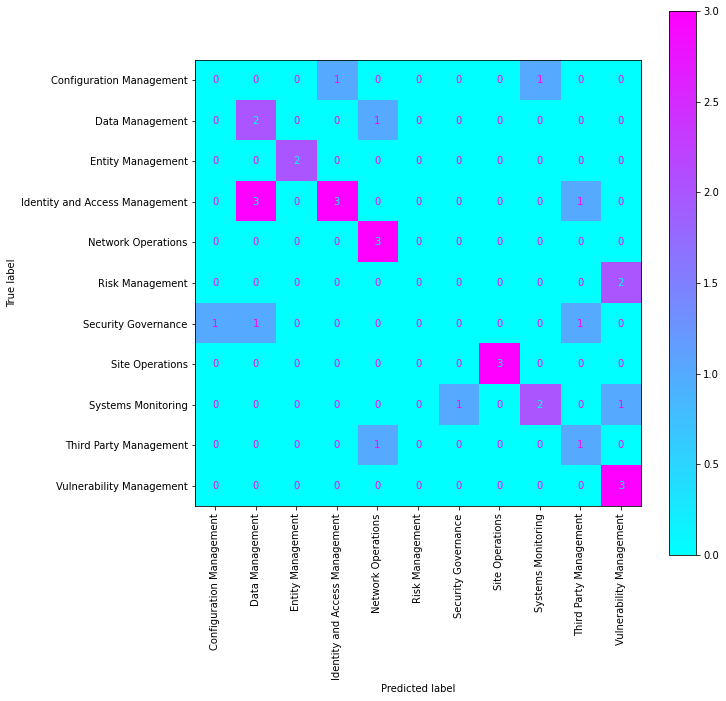

In [0]:
train_eval_bert(LogisticRegression(C=1e5), df_train_ccf, df_test_ccf)

## 2. SCF Classifier

In [0]:
df_train_scf, df_test_scf = train_test_split(df_scf_selected, test_size=0.20, stratify=df_scf_selected.control_category, random_state=42)
df_train_scf.shape, df_test_scf.shape

Out[8]: ((857, 8), (215, 8))

### Bert Zero Shot

In [0]:
labels = df_scf_selected["control_category"].unique().tolist()
labels

Out[9]: ['Security and Privacy Governance',
 'Asset Management',
 'Business Continuity and Disaster Recovery',
 'Change Management',
 'Cloud Security',
 'Compliance',
 'Configuration Management',
 'Continuous Monitoring',
 'Cryptographic Protections',
 'Data Classification and Handling',
 'Embedded Technology',
 'Endpoint Security',
 'Human Resources Security',
 'Identification and Authentication',
 'Incident Response',
 'Information Assurance',
 'Maintenance',
 'Mobile Device Management',
 'Network Security',
 'Physical and Environmental Security',
 'Privacy',
 'Project and Resource Management',
 'Risk Management',
 'Secure Engineering and Architecture',
 'Security Awareness and Training',
 'Technology Development and Acquisition',
 'Third-Party Management',
 'Vulnerability and Patch Management',
 'Web Security']

In [0]:
model = pipeline(model="facebook/bart-large-mnli", device=0, random_state=42)

/databricks/python/lib/python3.9/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are i

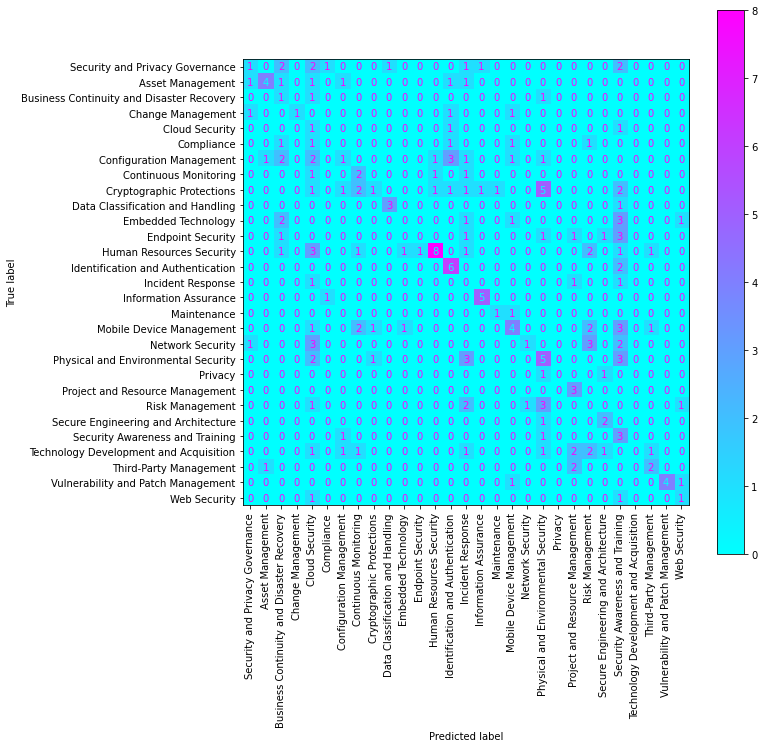

In [0]:
# Evaluate performance on test data
df_test_scf["zero_shot_prediction"] = df_test_scf["control"].apply(lambda x: model(x, candidate_labels=labels))
df_test_scf["zero_shot_prediction_label"] = df_test_scf["zero_shot_prediction"].apply(lambda x: get_predicted_label(x))

evaluate(labels, df_test_scf["zero_shot_prediction_label"], df_test_scf["control_category"])
# print(classification_report(, df_test["zero_shot_prediction_label"]))

/databricks/python/lib/python3.9/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<command-883378548096472>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scf_selected["zero_shot_prediction"] = df_scf_selected["control"].apply(lambda x: model(x, candidate_labels=labels))
<command-883378548096472>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scf_selected["ze

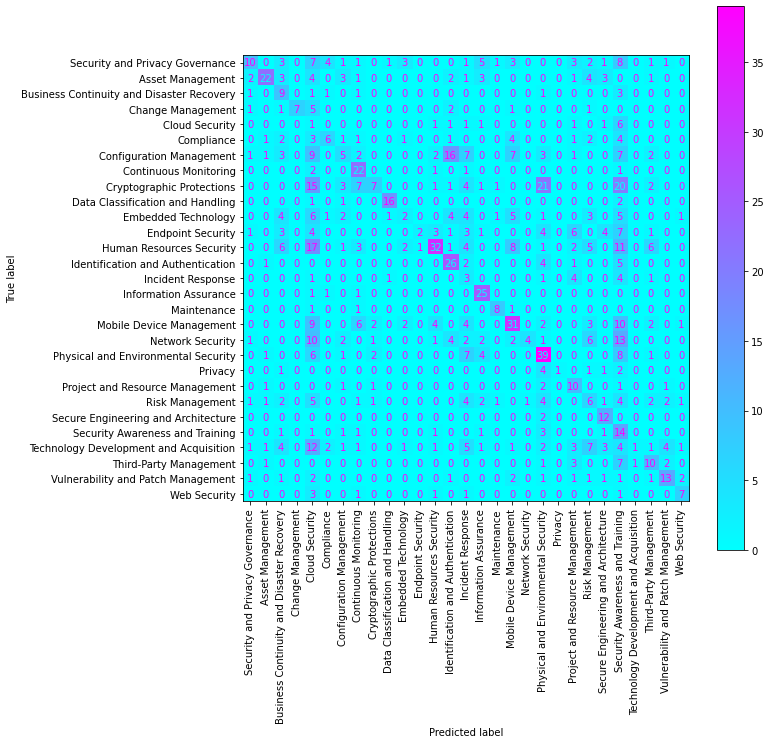

In [0]:
df_scf_selected["zero_shot_prediction"] = df_scf_selected["control"].apply(lambda x: model(x, candidate_labels=labels))
df_scf_selected["zero_shot_prediction_label"] = df_scf_selected["zero_shot_prediction"].apply(lambda x: get_predicted_label(x))

evaluate(labels, df_scf_selected["zero_shot_prediction_label"], df_scf_selected["control_category"])

### Logreg + CountVectorizer

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                           

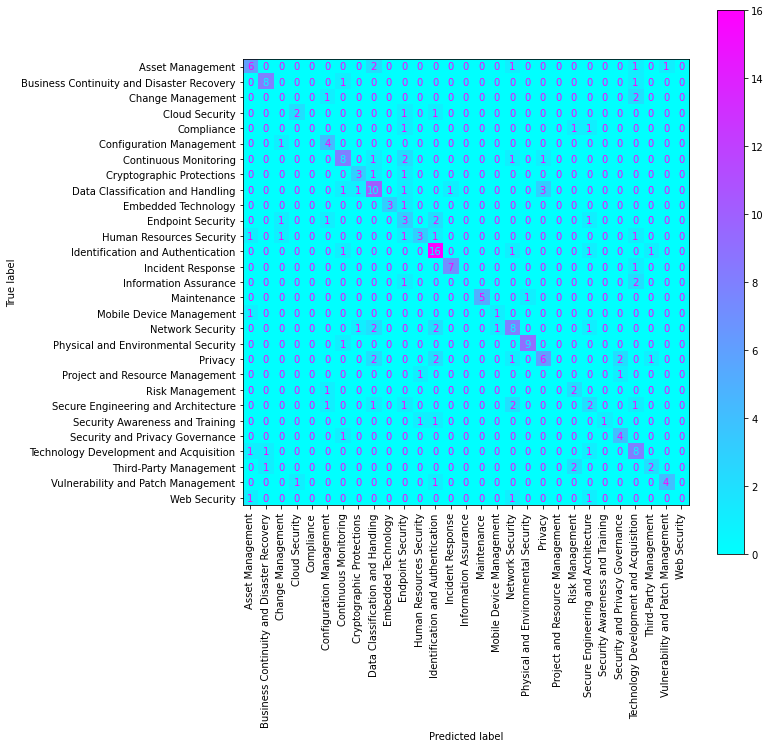

In [0]:
pipe_logreg = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 3), stop_words="english")), ('model', LogisticRegression(C=1e5))])
_, y_pred = train_eval(pipe_logreg, df_train_scf, df_test_scf)

In [0]:
df_test_scf["pred"] = y_pred
df_errors = df_test_scf[
    df_test_scf.apply(lambda x: ( (x["pred"] == "Data Classification and Handling") & (x["pred"] != x["control_category"])), axis=1)
]
display(df_errors.head())

org_id,control,framework_section_code,framework_section_title,source,control_category,control_sub_category,control_shortname,pred
null,Mechanisms exist to ensure systems associate security attributes with information exchanged between systems.,null,null,scf,Cryptographic Protections,null,Transmission of Security and Privacy Attributes,Data Classification and Handling
null,Mechanisms exist to enforce limitations on embedding data within other data types.,null,null,scf,Network Security,null,Embedded Data Types,Data Classification and Handling
null,"Mechanisms exist to track the origin, development, ownership, location and changes to systems, system components and associated data.",null,null,scf,Asset Management,null,Provenance,Data Classification and Handling
null,Mechanisms exist to issue data modeling guidelines to support tagging of sensitive/regulated data.,null,null,scf,Privacy,null,Data Tagging,Data Classification and Handling
null,Mechanisms exist to validate information output from software programs and/or applications to ensure that the information is consistent with the expected content.,null,null,scf,Secure Engineering and Architecture,null,Information Output Filtering,Data Classification and Handling


### MultinomialNB + CountVectorizer

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                           

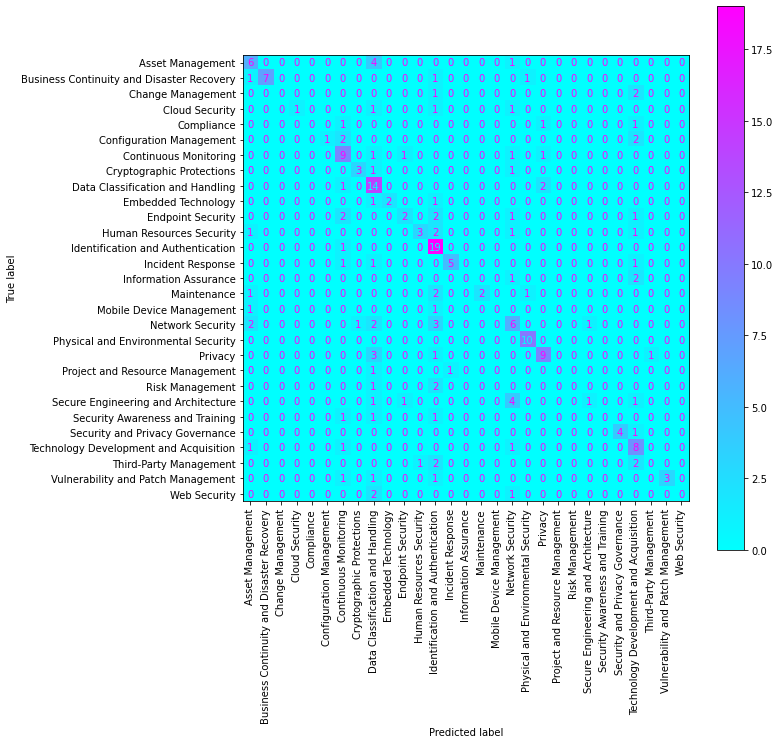

In [0]:
pipe_nb = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 3), stop_words="english")), ('model', MultinomialNB())])
pipe_nb = train_eval(pipe_nb, df_train_scf, df_test_scf)

### Logreg + Sentence Bert

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                           

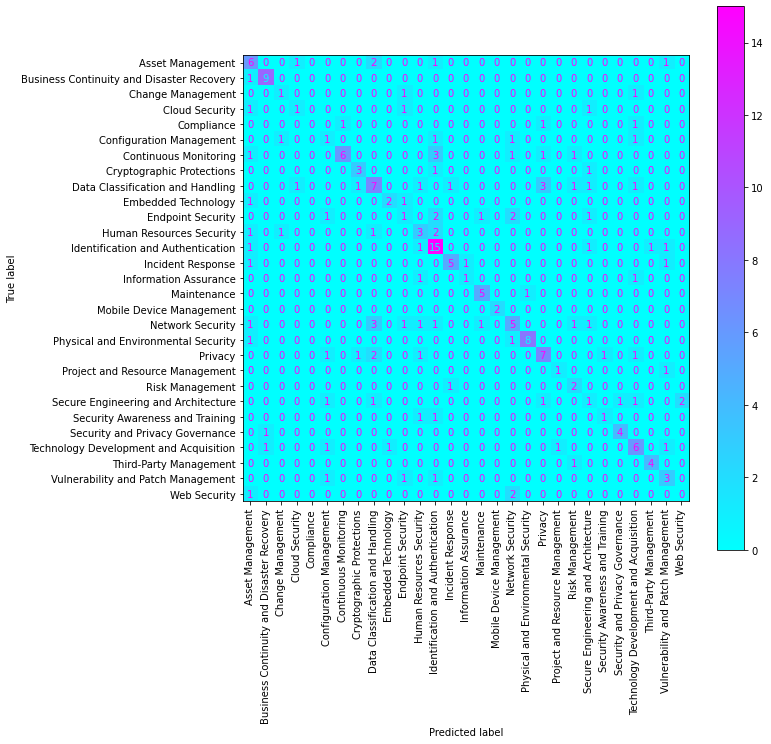

In [0]:
train_eval_bert(LogisticRegression(C=1e5), df_train_scf, df_test_scf)

# Data Augmentation with GPT3.5 generated data
- take 5 example from CCF and ask GPT to generate more and use it for data augementation

## Generate Data

In [0]:
df_sample = df_ccf_selected.groupby("control_category").sample(10, replace=True).sort_values(by="control_category")[["control_category", "control"]].drop_duplicates()

In [0]:
df_sample["gpt4_control"] = df_sample["control"].apply(lambda x: f'[EXAMPLE] "{x}"')

In [0]:
df_sample["control_category"].unique()

Out[39]: array(['Configuration Management', 'Data Management', 'Entity Management',
       'Identity and Access Management', 'Network Operations',
       'Risk Management', 'Security Governance', 'Site Operations',
       'Systems Monitoring', 'Third Party Management',
       'Vulnerability Management'], dtype=object)

In [0]:
df_sample[df_sample["control_category"]=="Configuration Management"]

,control_category,control,gpt4_control
49464,Configuration Management,Access to modify time data is restricted to au...,"[EXAMPLE] ""Access to modify time data is restr..."
49467,Configuration Management,"Where applicable, collaborative computing devi...","[EXAMPLE] ""Where applicable, collaborative com..."
49459,Configuration Management,[The organization] ensures security hardening ...,"[EXAMPLE] ""[The organization] ensures security..."
49466,Configuration Management,[The organization] implements only one primary...,"[EXAMPLE] ""[The organization] implements only ..."
49461,Configuration Management,[The organization] uses mechanisms to detect d...,"[EXAMPLE] ""[The organization] uses mechanisms ..."
49460,Configuration Management,"Where applicable, the information system defau...","[EXAMPLE] ""Where applicable, the information s..."
49468,Configuration Management,Installation of software or programs in the pr...,"[EXAMPLE] ""Installation of software or program..."


In [0]:
label = "Configuration Management"
print("You are a risk auditor.")
print(f"Write 20 control text for [{label}] based on the following [EXAMPLE].")
print()
print("Requirements:")
print('1. When you use "The organization". use this format  "[The organization]"')
print('2. Don\'t always start with "The organization"')
print("-----------------------------------------")
print()
print("\n\n".join(df_sample[df_sample["control_category"]==label]["gpt4_control"].tolist()))

You are a risk auditor.
Write 20 control text for [Configuration Management] based on the following [EXAMPLE].

Requirements:
1. When you use "The organization". use this format  "[The organization]"
2. Don't always start with "The organization"
-----------------------------------------

[EXAMPLE] "Access to modify time data is restricted to authorized personnel."

[EXAMPLE] "Where applicable, collaborative computing devices used at [The Organization] are configured to restrict remote activation and provide an explicit indication that they are in use."

[EXAMPLE] "[The organization] ensures security hardening and baseline configuration standards have been established according to industry standards and are reviewed and updated [in accordance with the organization-defined frequency]."

[EXAMPLE] "[The organization] implements only one primary function per server within the production environment; the information system maintains a separate execution domain for each executing process."



## Training with Augmented Data

In [0]:
df_gpt = pd.read_csv(".../gpt4_generated_examples.csv", header=0)
df_gpt['control'] = df_gpt['control'].apply(lambda x: x.strip('\"'))
df_gpt["source"] = "gpt"
df_gpt_selected = df_gpt[df_gpt["control_category"].isin(ccf_target_categories)]
df_gpt_selected.shape

Out[42]: (120, 3)

In [0]:
df_gpt_selected["control_category"].unique()

Out[43]: array(['Configuration Management', 'Data Management'], dtype=object)

In [0]:
df_train, df_test = train_test_split(df_ccf_selected, test_size=0.20, stratify=df_ccf_selected.control_category, random_state=42)
df_train.shape, df_test.shape

Out[44]: ((132, 10), (34, 10))

In [0]:
df_train_merge = pd.concat([df_train, df_gpt_selected])
df_train_merge.shape

Out[45]: (252, 10)

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                precision  

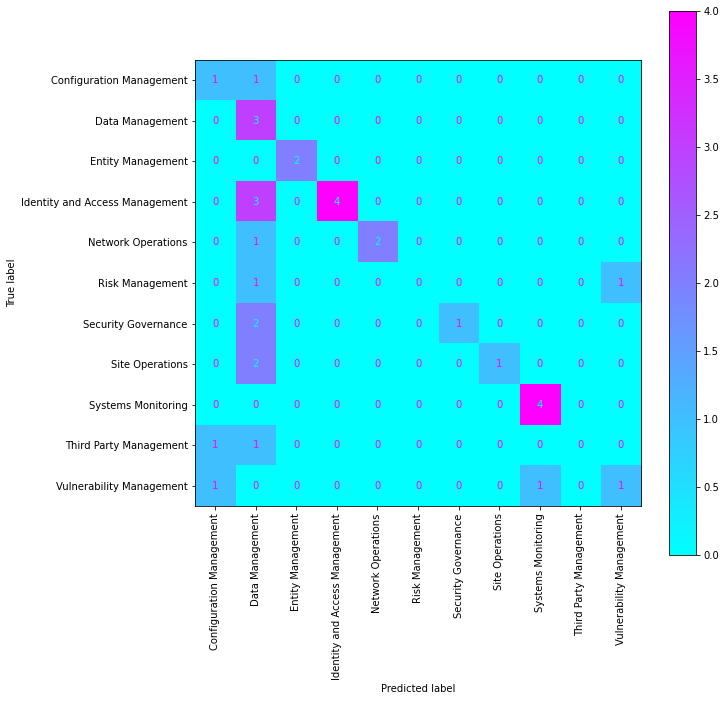

In [0]:
# logreg + CountVectorizer 
pipe_nb = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 3), stop_words="english")), ('model', MultinomialNB())])
_, prediction = train_eval(pipe_nb, df_train_merge, df_test)